In [35]:
import tensorflow as tf
from tensorflow.keras import models, layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import random

In [36]:
dataset, info = tfds.load(
    "imdb_reviews/plain_text",
    split=["train[:80%]", "train[80%:]", "test"],
    as_supervised=True,
    with_info=True
)

dataset_train_original = dataset[0]
dataset_validate_original = dataset[1]
dataset_test_original = dataset[2]
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
      title     = {Learning Word

In [37]:
dataset_train = dataset_train_original.cache()
dataset_train = dataset_train.shuffle(20_000)
dataset_train = dataset_train.batch(128)

dataset_validate = dataset_validate_original.cache()
dataset_validate = dataset_validate.batch(128)

In [4]:
vocabulary_size = 10_000
sequence_length = 128

encoder = layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_sequence_length=sequence_length,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int"
)
encoder.adapt(dataset_train_original.map(lambda text, label: text).batch(512))

In [5]:
def render_history(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.show()

In [6]:
model = models.Sequential()
model.add(encoder)
model.add(layers.Embedding(input_dim=vocabulary_size, output_dim=32))
model.add(layers.LSTM(64, return_sequences=True)) # Long Short Term Memory
model.add(layers.LSTM(72, return_sequences=True))
model.add(layers.LSTM(81))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 128)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 128, 32)           320000    
                                                                 
 lstm (LSTM)                 (None, 128, 64)           24832     
                                                                 
 lstm_1 (LSTM)               (None, 128, 72)           39456     
                                                                 
 lstm_2 (LSTM)               (None, 81)                49896     
                                                                 
 dense (Dense)               (None, 1)                 82        
                                                        

In [8]:
history = model.fit(
    dataset_train,
    epochs=5,
    validation_data=dataset_validate,
)

Epoch 1/5
157/157 [==============================] - 95s 603ms/step - loss: 0.4729 - accuracy: 0.7653 - val_loss: 0.3733 - val_accuracy: 0.8352
Epoch 2/5
157/157 [==============================] - 92s 589ms/step - loss: 0.2798 - accuracy: 0.8907 - val_loss: 0.3736 - val_accuracy: 0.8370
Epoch 3/5
157/157 [==============================] - 93s 593ms/step - loss: 0.2331 - accuracy: 0.9133 - val_loss: 0.4668 - val_accuracy: 0.8364
Epoch 4/5
157/157 [==============================] - 92s 587ms/step - loss: 0.1831 - accuracy: 0.9358 - val_loss: 0.4439 - val_accuracy: 0.8306
Epoch 5/5
157/157 [==============================] - 92s 586ms/step - loss: 0.1457 - accuracy: 0.9510 - val_loss: 0.4823 - val_accuracy: 0.8340


In [10]:
model = models.Sequential()
model.add(encoder)
model.add(layers.Embedding(input_dim=vocabulary_size, output_dim=32))
model.add(layers.Bidirectional(layers.LSTM(64))) # sometimes in Musicmodels
model.add(layers.GRU())
model.add(layers.SimpleRNN(64)) # DONT USE, not good.

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 128)              0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, 128, 32)           320000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              49664     
 nal)                                                            
                                                                 
Total params: 369,664
Trainable params: 369,664
Non-trainable params: 0
_________________________________________________________________


Tensorflow Hub

In [38]:
import tensorflow_hub as hub

url = "https://tfhub.dev/google/Wiki-words-250/2"

embedding = hub.load(url)

In [14]:
#embedding(["taser test text hello"])

In [16]:
embedding

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f06c296ae90>

In [20]:
for text, label in dataset_train_original.take(5):
  print(text)
  print(label)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on t

In [39]:
embedding_layer = hub.KerasLayer(
    url,
    trainable=False,
    input_shape=[],
    dtype=tf.string
)

embedding_layer

In [44]:
model = models.Sequential()
model.add(embedding_layer)
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))


model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 250)               252343750 
                                                                 
 dense_12 (Dense)            (None, 32)                8032      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 252,351,815
Trainable params: 8,065
Non-trainable params: 252,343,750
_________________________________________________________________


In [45]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [46]:
history = model.fit(
    dataset_train,
    epochs=30,
    validation_data=dataset_validate,
)

Epoch 1/30
157/157 [==============================] - 3s 14ms/step - loss: 0.6210 - accuracy: 0.6611 - val_loss: 0.5783 - val_accuracy: 0.7064
Epoch 2/30
157/157 [==============================] - 2s 13ms/step - loss: 0.5536 - accuracy: 0.7277 - val_loss: 0.5328 - val_accuracy: 0.7448
Epoch 3/30
157/157 [==============================] - 2s 14ms/step - loss: 0.5243 - accuracy: 0.7490 - val_loss: 0.5149 - val_accuracy: 0.7540
Epoch 4/30
157/157 [==============================] - 2s 13ms/step - loss: 0.5103 - accuracy: 0.7558 - val_loss: 0.4928 - val_accuracy: 0.7694
Epoch 5/30
157/157 [==============================] - 2s 14ms/step - loss: 0.4987 - accuracy: 0.7610 - val_loss: 0.4903 - val_accuracy: 0.7668
Epoch 6/30
157/157 [==============================] - 2s 13ms/step - loss: 0.4898 - accuracy: 0.7693 - val_loss: 0.4751 - val_accuracy: 0.7806
Epoch 7/30
157/157 [==============================] - 2s 13ms/step - loss: 0.4885 - accuracy: 0.7686 - val_loss: 0.4820 - val_accuracy: 0.7714

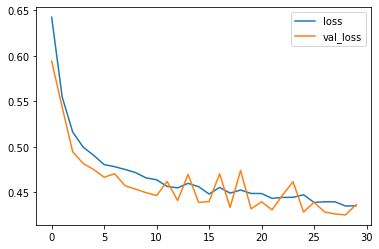

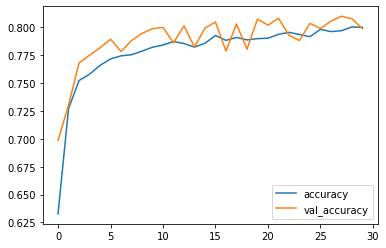

In [43]:
render_history(history)